In [73]:
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline

In [74]:
DATA_DIR = '../data/scan_data/taurus_band_tests'
DATA_FILE = '20260204_155051.csv'
data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE), comment = '#')
data = data.drop(index=0)
data

,timestamp,position_mm,x,y,r,theta
1,1.770242e+09,0.243164,-1.508871e-05,-0.000016,0.000022,-133.636917
2,1.770242e+09,0.548096,-5.537200e-05,-0.000035,0.000066,-147.592194
3,1.770242e+09,0.855469,-1.755794e-05,-0.000013,0.000022,-144.090256
4,1.770242e+09,1.158203,-1.443793e-05,-0.000011,0.000018,-141.733749
5,1.770242e+09,1.465576,6.037135e-07,-0.000001,0.000001,-64.650230
...,...,...,...,...,...,...
650,1.770242e+09,197.723633,2.262760e-06,-0.000028,0.000028,-85.378838
651,1.770242e+09,198.031738,-9.941335e-06,-0.000004,0.000011,-155.808563
652,1.770242e+09,198.327148,-5.921519e-06,-0.000014,0.000015,-113.485291
653,1.770242e+09,198.635986,-1.959102e-05,-0.000018,0.000026,-137.783142


In [75]:
TIMESTAMPS = data['timestamp'].values * u.s
POS = data['position_mm'].values * u.mm
R = data['r'].values * u.V  # Assuming lock-in outputs in V
X = data['x'].values * u.V
Y = data['y'].values * u.V
THETA = data['theta'].values * u.deg

print(f"Total samples: {len(POS)}")
print(f"Position range: {POS.min():.2f} to {POS.max():.2f}")
print(f"Scan duration: {(TIMESTAMPS[-1] - TIMESTAMPS[0]):.2f}")

Total samples: 654
Position range: 0.24 mm to 198.95 mm
Scan duration: 66.25 s


In [76]:
OPD = POS * 2
I = (R - np.mean(R)).to(u.mV)

In [77]:
OPD_INTERP = np.linspace(OPD.min(), OPD.max(), OPD.size)
I_INTERP = np.interp(OPD_INTERP, OPD, I)

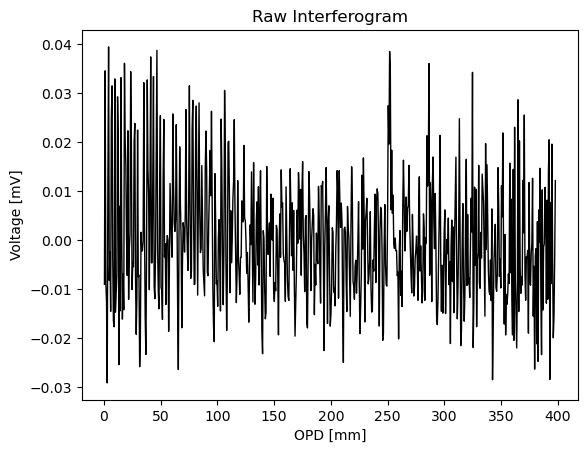

In [78]:
plt.plot(OPD_INTERP, I_INTERP, 'k', lw=1)
plt.title('Raw Interferogram')
plt.ylabel(f'Voltage [{I.unit}]')
plt.xlabel(f'OPD [{OPD.unit}]')
plt.show()

In [79]:
SPECTRUM = np.fft.rfft(I_INTERP)
POWER = np.abs(SPECTRUM)**2

WAVENUMBERS = np.fft.rfftfreq(OPD_INTERP.size, np.diff(OPD_INTERP).mean()).to(1/u.cm)
FREQS = WAVENUMBERS.to(u.GHz, equivalencies=u.spectral())

nyq_freq = (const.c / (2 * np.diff(OPD_INTERP).mean())).to(u.GHz)
print(f"Nyquist frequency: {nyq_freq:.1f}")

Nyquist frequency: 246.3 GHz


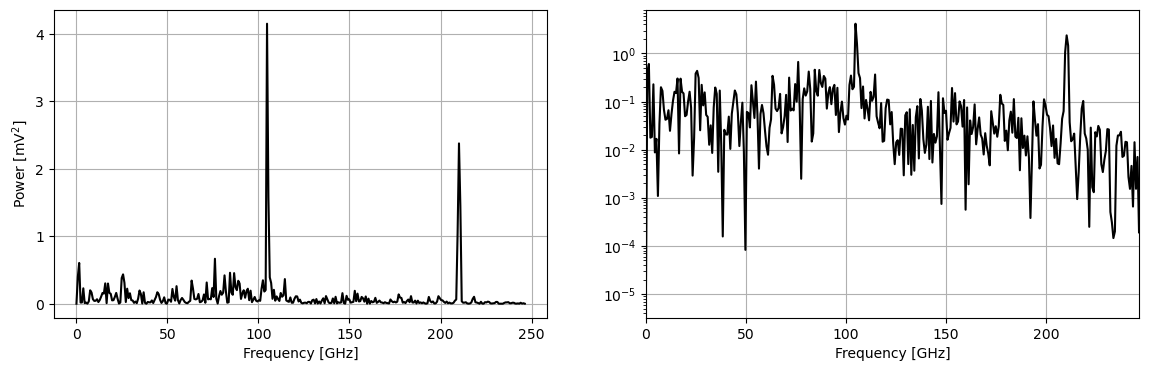

In [80]:
POWER_UNIT = r'$\mathrm{mV^2}$'

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(FREQS, POWER, color='k', lw=1.5)
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
#axes[0].set_xlim(60, 100)
axes[0].grid()

axes[1].semilogy(FREQS, POWER, color='k', lw=1.5)
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
axes[1].grid()
plt.show()
